# Neural CF GMF (PyTorch)

**NOTE**: Referencing my CMPE 256 Adv Data Mining hw4 on PyTorch Neural CF GMF for my semester team project. We'll leverage this notebook as a basis to repurpose it from movie dataset to yahoo finance stock dataset. My teammates include:

- James Guzman, Josef Bustamante, Anshul Shandilya

For my programming assignment, I will be switching from TensorFlow to **PyTorch** to implement **Generalized Matrix Factorization** using Collaborative Filtering based **Neural Networks with Embeddings** trained and validated on the Movie Night Dataset.

![](neural_cf_mf.png)

**Contributor: James Guzman, SJSU MS AI**

### PyTorch CF NN Learning Resources

For learning how to design and develop PyTorch CF NN architecture, I referenced this Kaggle Deep Learning based Recommender System notebook that used a different movie dataset than ours, which is the movie lens dataset and instead of training the CF NN on predicting movie rating, it is predicting movie interaction and so forth. Also for our GMF NN for this assignment we need to use element wise multiplication whereas in the CF NN example, they use torch concatentation. I took what I learned from this notebook and applied it to this assignment. Here is the link: https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems

For learning how to do conversions from TensorFlow Keras to PyTorch syntax for developing Neural CF architecture and debugging pytorch issues related to building the custom Dataset and training the GMF CF NN, I referenced perplexity.ai (GPT-3) for prompt engineering examples, which also shared links with me in its generated responses: https://www.perplexity.ai/search/For-Neural-Collaborative-ATK.g6f0QkegMfRejs3dGw?s=c

I also referenced this video tutorial after I had already written most of the code, but was referencing this video to help me with debugging purposes and to compare my custom PyTorch Movie Dataset and my GMF CF NN architecture to theirs. Here is the title "Building Recommender System with PyTorch using Collaborative Filtering" and link: https://www.youtube.com/watch?v=Wj-nkk7dFS8

### TensorFlow to PyTorch Assignment Explanations

Also one more important note, I kept the TensorFlow GMF Architecture code commented out that originally came with this assignment and I added ### Label Me (JG) ### in my PyTorch GMF Architecture code covering most of the action items that were required in the TensorFlow code, but I explained it with respect to PyTorch.

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from pytorch_model_summary import summary

In [2]:
def mkdir_prep_dir(dirpath):
    """make preprocess directory if doesn't exist"""
    prep_dir = dirpath
    if not os.path.exists(prep_dir):
        os.makedirs(prep_dir)
    return prep_dir

In [3]:
print("PyTorch version {}".format(torch.__version__))

if torch.cuda.is_available():
    gpu_device = torch.device("cuda")
    print("Running on GPU {}".format(torch.cuda.get_device_name(gpu_device)))
else:
    raise Exception("Not connected to a GPU")

PyTorch version 2.0.1+cu117
Running on GPU NVIDIA GeForce RTX 4090


In [4]:
# NOTE: Original Keras batch_size=50, for now PyTorch BATCH_SIZE=1 for verifying we can train
BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
LEARNING_RATE = 1e-2
NUM_EPOCHS = 5
dataset_name = "movie_night"
DEBUG = False

In [5]:
#grab data and view
rating_df = pd.read_csv('movie_night_utilitymatrix_F23.csv')
rating_df = rating_df.rename(columns={'user':'u_id','movie':'m_id','rating':'rate'})
rating_df.head()

,u_id,m_id,rate
0,1,2,5.0
1,1,3,5.0
2,1,7,3.0
3,1,11,2.0
4,1,14,5.0


In [6]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4694 entries, 0 to 4693
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   u_id    4694 non-null   int64  
 1   m_id    4694 non-null   int64  
 2   rate    4694 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 110.1 KB


In [7]:
# Model may requires seed for embeddings to work depending on keras/tf version
# rating_df = rating_df.sample(frac=1, random_state=73)

#splits data into inputs (X) and ratings (y)
X = rating_df[['u_id', 'm_id']]
y = rating_df["rate"]

In [8]:
#create the train and test set. test is 25%
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 3520
> Test set ratings: 1174


In [9]:
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, user_movie_df, rating_pd_series):
        # self.um_2d_array = user_movie_2darray
        self.X_u_id = user_movie_df["u_id"].tolist()
        self.X_m_id = user_movie_df["m_id"].tolist()
        self.rating_list = rating_pd_series.tolist()

    def __len__(self):
        return len(self.X_u_id)

    def __getitem__(self, idx):
        if DEBUG:
            print("idx = {}".format(idx))

        user = self.X_u_id[idx]
        user_tensor = torch.tensor(user).int()
        if DEBUG:
            print("user = {}".format(user))
            print("user_tensor = {}".format(user_tensor))
            
        movie = self.X_m_id[idx]
        movie_tensor = torch.tensor(movie).int()
        if DEBUG:
            print("movie = {}".format(movie))
            print("movie_tensor = {}".format(movie_tensor))

        rating_label = self.rating_list[idx]
        rating_tensor = torch.tensor(rating_label).float()
        return user_tensor, movie_tensor, rating_tensor

In [10]:
movie_train_dataset = MovieDataset(X_train, y_train)

In [11]:
movie_test_dataset = MovieDataset(X_test, y_test)

In [12]:
print("movie_train_dataset len = {}".format(len(movie_train_dataset)))

movie_train_dataset len = 3520


In [13]:
print("movie_test_dataset len = {}".format(len(movie_test_dataset)))

movie_test_dataset len = 1174


In [14]:
movie_train_loader = DataLoader(movie_train_dataset, batch_size = BATCH_SIZE, shuffle=True)

In [15]:
movie_test_loader = DataLoader(movie_test_dataset, batch_size = TEST_BATCH_SIZE, shuffle=False)

In [16]:
for idx, (user_input, movie_input, rating_targets) in enumerate(movie_train_loader):
    print(f"Sample {idx}:")
    print(f" User Input shape: {user_input.shape}")
    print(f" User Input: {user_input}")
    print(f" Movie Input shape: {movie_input.shape}")
    print(f" Movie Input: {movie_input}")
    print(f" Rating Labels shape: {rating_targets.shape}")
    print(f" Rating Labels: {rating_targets}")
    if idx == 0:
        break

Sample 0:
 User Input shape: torch.Size([4])
 User Input: tensor([394, 166, 270,  72], dtype=torch.int32)
 Movie Input shape: torch.Size([4])
 Movie Input: tensor([ 6, 18,  7, 16], dtype=torch.int32)
 Rating Labels shape: torch.Size([4])
 Rating Labels: tensor([4., 2., 5., 5.])


In [17]:
# the input dimension is the number of unique entries
in_u_dim = len(rating_df["u_id"].unique())
in_m_dim = len(rating_df["m_id"].unique())
 
latent_out_dim = 8 #desired embedding length, determines complexity

In [18]:
in_u_dim

482

In [19]:
in_m_dim

20

In [21]:
# ALERT for Reader, ust a friendly reminder, I decided to do this assignment using PyTorch
# instead of TensorFlow for learning purposes. Here is my GMF CF NN architecture. You will
# see ### label me ### like in the original TensorFlow Keras skeleton code. I added my initials
# ### label me (JG) ### too.

class GMFact(nn.Module):
    """ GMF for Neural CF

        Args:
            in_u_emb (int): number of unique users for user embedding
            in_m_emb (int): number of unique movies for item embedding
            out_dim (int): desired embedding length determining complexity
    """
    def __init__(self, in_u_emb = 1, in_m_emb = 1, embedding_size = 1, hidden_features = 16):
        super(GMFact, self).__init__()

        ###label me (JG):### 
            # In Keras, we define Input layers for user and movie shape, but in PyTorch we define Input Tensors for them, 
            # which are located in MovieDataset class's object and then we pass them to our GMFact via DataLoader

        if DEBUG:
            print("in_u_emb = {}".format(in_u_emb))
            print("in_m_emb = {}".format(in_m_emb))
            print("embedding_size = {}".format(embedding_size))
        ###label me (JG):### 
            # Like Keras, PyTorch we have User Embedding layer followed by Item Embedding layer
        self.user_embedding = nn.Embedding(num_embeddings = in_u_emb, embedding_dim = embedding_size)
        self.item_embedding = nn.Embedding(num_embeddings = in_m_emb, embedding_dim = embedding_size)
        
        # In Keras, the Single Neuron layer indicated by Dense, in PyTorch, it is by nn.Linear 
            # and kernel initializer for lecun uniform in Keras is kaiming_uniform_() in PyTorch
            # we also use a fan_in mode, so kiaming_uniform bases its scaling factor on the in features
        self.fc1 = nn.Linear(in_features = embedding_size, out_features = 1)
        nn.init.kaiming_uniform_(self.fc1.weight, mode="fan_in", nonlinearity="linear")

            # Like Keras, PyTorch has a Sigmoid activation
        self.sigmoid_activation = nn.Sigmoid()

    def forward(self, user_input, item_input):
        ###label me (JG):### 
            # Passing user and item inputs through embedding layers
        if DEBUG:
            print("user_input.shape = {}".format(user_input))
            print("item_input.shape = {}".format(item_input))
        user_embedding_layer = self.user_embedding(user_input)
        item_embedding_layer = self.item_embedding(item_input)

        if DEBUG:
            print("user_embedding_layer.shape = {}".format(user_embedding_layer.shape))
            print("item_embedding_layer.shape = {}".format(item_embedding_layer.shape))

        ###label me (JG):### 
            # In PyTorch GMF, we do element wise multiplication for merging embedding layers 
            # However, we dont flatten the result like we would do in Keras since Pytorch preserve shape of tensors
        similarity_vector = torch.mul(user_embedding_layer, item_embedding_layer)
        if DEBUG:
            print("after mult: similarity_vector.shape = {}".format(similarity_vector.shape))
            print("after mult: similarity_vector = {}".format(similarity_vector))

        # NOTE: If we were to develop NCF, we could use concatenation below instead of multiplication above
        # similarity_vector = torch.cat([user_embedding_layer, item_embedding_layer], dim=-1)
        # print("after cat: similarity_vector.shape = {}".format(similarity_vector.shape))
        
        ###label me###  
            # Passing similarity vectors through Linear layers and sigmoid activation to obtain movie rating predictions
        similarity_vector = self.fc1(similarity_vector)
        if DEBUG:
            print("after Linear: similarity_vector.shape = {}".format(similarity_vector.shape))
        pred_out = self.sigmoid_activation(similarity_vector)
        if DEBUG:
            print("after sigmoid: pred_out.shape = {}".format(pred_out.shape))

        return pred_out

In [22]:
# Store Loss Values During Training
train_mse_loss_values = []
train_rmse_loss_values = []

# Store Loss Values During Validation
val_mse_loss_values = []
val_rmse_loss_values = []

In [23]:
def save_checkpoint(state, filename="best_gmfact_dnn.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)

In [24]:
def compute_metrics(metrics, outputs, targets):
    with torch.no_grad():
        for metric in metrics:
            metric_value = metric(targets, outputs)
            if DEBUG:
                print(f"{metric.__name__}: {metric_value:.4f}")

In [25]:
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

In [26]:
def train_gmf(train_loader, dnn_model, optimizer, loss_criterion, metrics):
    train_loop = tqdm(train_loader)

    if DEBUG:
        print("Running train_gmf")
    for batch_idx, (user_input, movie_input, rating_targets) in enumerate(train_loop):
        if DEBUG:
            print("Setting user, movie and rating on gpu device")
        user_input = user_input
        movie_input = movie_input
        rating_targets = rating_targets.unsqueeze(1)

        if DEBUG:
            print("Train Neural CF on user & movie inputs calculating MSE loss")
        optimizer.zero_grad()
        pred_targets = dnn_model(user_input, movie_input)
        if DEBUG:
            print("pred_targets = {}".format(pred_targets))
        loss = loss_criterion(pred_targets, rating_targets)
        rmse_loss = rmse(rating_targets, pred_targets)
        if DEBUG:
            print("MSE loss = {}".format(loss))
            print("Compute Metrics: RMSE")
            
        if DEBUG:
            print("Backpropagate using MSE Loss and SGD optimizer")
        loss.backward()
        optimizer.step()

        # Save the training loss values to list
        train_mse_loss_values.append(loss.item())
        train_rmse_loss_values.append(rmse_loss.item())
        
        train_loop.set_postfix(train_mse_loss=loss.item(), train_rmse_loss=rmse_loss.item())

In [27]:
def validate_gmf(val_loader, dnn_model, loss_criterion, metrics):
    val_loop = tqdm(val_loader)

    if DEBUG:
        print("Running validate_gmf")
    with torch.no_grad():
        for batch_idx, (user_input, movie_input, rating_targets) in enumerate(val_loop):
            if DEBUG:
                print("Setting user, movie and rating on gpu device")
            user_input = user_input
            movie_input = movie_input
            rating_targets = rating_targets.unsqueeze(1)
            pred_targets = dnn_model(user_input, movie_input)

            loss = loss_criterion(pred_targets, rating_targets)
            rmse_loss = rmse(rating_targets, pred_targets)
            
            if DEBUG:
                print("Compute Metrics: RMSE")

            # Save the validation loss values to list
            val_mse_loss_values.append(loss.item())
            val_rmse_loss_values.append(rmse_loss.item())
            
            val_loop.set_postfix(val_mse_loss=loss.item(), val_rmse_loss=rmse_loss.item())

In [42]:
def plot_dnn_loss_curve(mse_loss_values, rmse_loss_values, plot_title, plot_filename):
    plt.title(plot_title)
    plt.plot(mse_loss_values, label="MSE Loss")
    plt.plot(rmse_loss_values, label="RMSE Loss")
    plt.legend()
    plt.savefig(plot_filename)
    plt.show()

In [29]:
def train_neuralCF_over_epochs(neural_cf_dnn, optimizer, loss_criterion, metrics):
    if DEBUG:
        print("Running train neural CF over epochs")
    
    step = 100
    for epoch in range(NUM_EPOCHS):
        if DEBUG:
            print("Epoch {}: Train across batch_idx and movie_data and target from train_loader".format(epoch))
        train_gmf(movie_train_loader, neural_cf_dnn, optimizer, loss_criterion, metrics)

        if DEBUG:
            print("Creating checkpoint")
        checkpoint = {
            "state_dict": neural_cf_dnn.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        mkdir_prep_dir("{}/neural_cf_dnns".format(dataset_name))
        filename = "{}/neural_cf_dnns/gmfact_dnn_{}.pth.tar".format(dataset_name, step)
        save_checkpoint(checkpoint, filename=filename)

        if DEBUG:
            print("Running Evaluation on Neural GMF")

        validate_gmf(movie_test_loader, neural_cf_dnn, loss_criterion, metrics)
        
        step += 100

Initially, we used the unique users and unique movies, but I found that to have index out of range issue. I switched to using max() on users and movies to get the unique number and added +1 to account for the zero index.

In [30]:
user_dim_num = rating_df["u_id"].max()+1

In [31]:
user_dim_num

485

In [32]:
movie_dim_num = rating_df["m_id"].max()+1

In [33]:
movie_dim_num

21

In [34]:
# Note: for input user and movie embedding numbers, we +1 to account for zero-indexed
gmfact_dnn = GMFact(in_u_emb = user_dim_num, in_m_emb = movie_dim_num, embedding_size = latent_out_dim)

In [35]:
sgd_optimizer = optim.SGD(gmfact_dnn.parameters(), lr=LEARNING_RATE)

In [36]:
mse_criterion = nn.MSELoss()

In [37]:
eval_metrics = [rmse]

In [35]:
# summary(gmfact_dnn, torch.zeros((1, 1, 1)))

In [42]:
# ALERT for Reader, just a friendly reminder, I decided to do this assignment using PyTorch
# instead of TensorFlow for learning purposes. My goal was to design and develop PyTorch GMF
# NN Architecture with similar behavior as TensorFlow Keras. I am keeping this TensorFlow Keras
# skeleton code here for reference in case it helps to make sure I covered the items, but with
# respect to using PyTorch.

# Model
# from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

# def GMFact():
    
###--------------------- Instructions!
### Take a look at the General Matrix Factorization Architecture.png
### Of the 4 architecture components (single neuron, element-wise multiplication layer, embedding layer, and input layer)
### label the appropriate component to the appropriate comment denoted with: ###label me###
### Additionally, fillout code where ever you see ##, please check the above # for instructions
###-----------------------------------

    ###label me###
    # user = Input(name = 'u_in', shape = [1])
    # movie = Input(name = 'm_in', shape = [1])

    # ###label me###
    # user_embedding = Embedding(name = 'u_emb',
    #                    input_dim = ##,                                  #what is the dimension of the user embedding? Hint: it should be the number of unique entries. This variable was created in the previous code block.
    #                    output_dim = ##)(user)                           #what is the dimension of the desired output embedding dimension? Hint: see what we did with the movie_embedding
    
    # movie_embedding = Embedding(name = 's_emb',
    #                    input_dim = in_m_dim, 
    #                    output_dim = latent_out_dim)(movie)
    
    ###label me###
    # x = tf.keras.layers.##()([user_embedding, movie_embedding])         #We need to specify the correct layer type to element-wise multiply the user_embedding with the movie_embedding. Hint: the name of the layer is one of these: https://keras.io/api/layers/merging_layers/
    # x = Flatten()(x)

    ###label me###   
    # x = Dense(##, ##)(x)                                                #add a single neuron and set the 'kernel_initializer' to 'lecun_uniform' see example: https://github.com/fractus-io/keras-tutorial/blob/master/README.md#initializers
    # x = Activation("sigmoid")(x)
    
    # model = Model(inputs=[user, movie], outputs=x)

    # model.compile(
    #   optimizer='sgd',
    #   loss='mse',
    #   metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
#     return model

# with tpu_strategy.scope(): 
#   model = GMFact()
# model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 u_in (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 m_in (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 u_emb (Embedding)              (None, 1, 8)         3568        ['u_in[0][0]']                   
                                                                                                  
 s_emb (Embedding)              (None, 1, 8)         160         ['m_in[0][0]']                   
                                                                                            

In [43]:
## NOTE: This was the previous TensorFlow Keras train code
##       Also just keeping the results here, so we can see our PyTorch results and compare our Loss with
##       this previous one from TensorFlow Keras.
##
# # Model training
# batch_size = 50
# history = model.fit(
#     x=X_train_array,
#     y=y_train,
#     batch_size=batch_size,
#     epochs=1,
#     verbose=1,
#     validation_data=(X_test_array, y_test)
# )

# model.save_weights('gmf.h5')

68/68 [==============================] - 6s 50ms/step - loss: 11.9475 - root_mean_squared_error: 3.4565 - val_loss: 11.2282 - val_root_mean_squared_error: 3.3508


In [38]:
# NOTE: Here is my PyTorch train code calling a train function where we pass our GMF DNN
# model, SGD optimizer, MSE Loss Criterion Function, and eval_metrics (mainly holding RMSE).
# We train the model printing the MSE Loss and RMSE Loss during training. We also validate
# our GMF DNN model on the testing set and print the MSE Loss and RMSE Loss.
train_neuralCF_over_epochs(
    gmfact_dnn, 
    sgd_optimizer, 
    mse_criterion, 
    eval_metrics
)

  0%|          | 0/880 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/294 [00:00<?, ?it/s]

  0%|          | 0/880 [00:00<?, ?it/s]

=> Saving Checkpoint


  0%|          | 0/294 [00:00<?, ?it/s]

In [44]:
# final_RMSE = (history.history['root_mean_squared_error'])[-1]
# final_RMSE

3.4565114974975586

Finally, we show the final RMSE scores from training and validation, and then we show graphs of our PyTorch GMFact DNN from training and validation.

In [39]:
final_train_RMSE = train_rmse_loss_values[-1]
print("final_train_RMSE = {}".format(final_train_RMSE))

final_train_RMSE = 2.961578369140625


In [40]:
final_val_RMSE = val_rmse_loss_values[-1]
print("final_val_RMSE = {}".format(final_val_RMSE))

final_val_RMSE = 3.0039865970611572


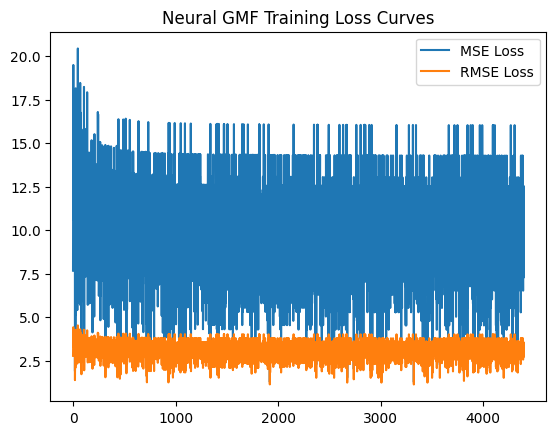

In [43]:
plot_dnn_loss_curve(train_mse_loss_values, train_rmse_loss_values, "Neural GMF Training Loss Curves", "gmf_train_loss_curves.jpg")

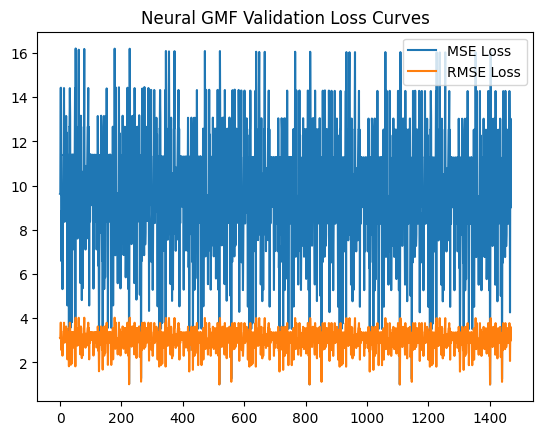

In [44]:
plot_dnn_loss_curve(val_mse_loss_values, val_rmse_loss_values, "Neural GMF Validation Loss Curves", "gmf_val_loss_curves.jpg")